# Notebook to demonstrate Custom Training Loop 
# (ResNet20 for CIFAR10 classification)

We will be using a ResNet20 to classify CIFAR10 images.

We will firstly do it using Keras's model.fit.
Thereafter, we will do our own custom training loop to get similar results.

**Requirements:**
- Python 3.0 and above
- Tensorflow 2.x
- tqdm

**Outcome:**

With 80 training epochs, the test accuracy should reach around 90%


# Download and Augment Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Add
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import GradientTape
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a data augmentation stage with horizontal flipping and translation
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomTranslation(
        height_factor = (-0.1,0.1),
        width_factor = (-0.1,0.1),
        fill_mode="constant")
    ]
)       

# Create Data Loaders
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).map(lambda x, y: (data_augmentation(x), y))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Show a sample image

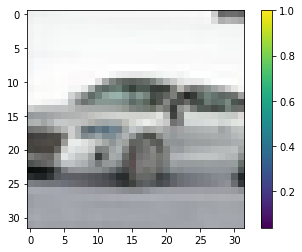

Class: automobile


In [2]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

imagenum = np.random.randint(len(x_train))
show_image(x_train[imagenum].reshape(32, 32, 3))
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print("Class:", classes[int(y_train[imagenum])])

# Define ResNet

In [3]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Input, Activation, Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    
    # Just a test to see if batch norm is important
#     batch_normalization = False
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = Add()([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = Add()([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Visualize your ResNet 20 Model

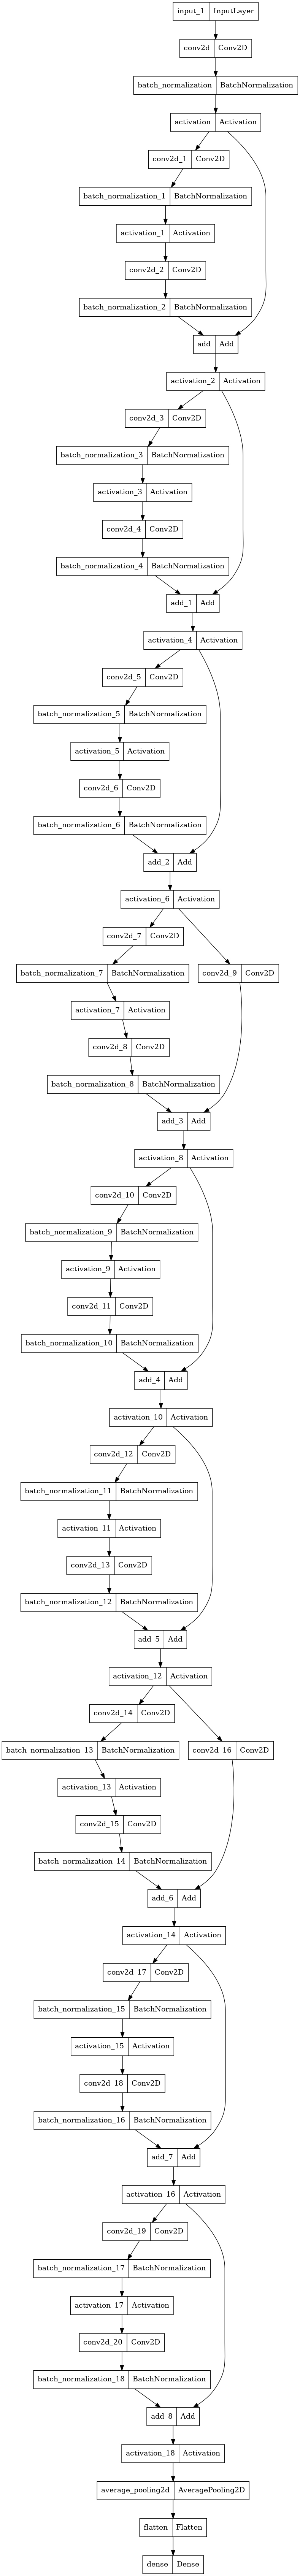

In [4]:
model = resnet_v1(input_shape=(32, 32, 3), depth=20)
plot_model(model)

# Graph Plotting Code

In [8]:
def plot_metrics(metric_name, title, append = 'val_'):
    plt.title(title)
    plt.xticks(list(range(len(history.history[metric_name]))))
    plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(history.history[append + metric_name], color = 'green', label = append + metric_name)
    plt.xlabel('Epoch Number')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Training Using Keras Model.Fit

In [6]:
model = resnet_v1(input_shape=(32, 32, 3), depth=20)
optimizer = SGD(learning_rate = 0.01)
loss_object = SparseCategoricalCrossentropy(from_logits=False, reduction='sum')
accuracy_object = SparseCategoricalAccuracy()

model.compile(optimizer = optimizer, loss = loss_object, metrics = [accuracy_object])
with open('template1.txt', 'w') as f:
    history = model.fit(train_ds, validation_data = test_ds, epochs = 10)    
    print(history.history, file = f)

Epoch 1/10
1563/1563 [==============================] - 132s 83ms/step - loss: 53.1947 - sparse_categorical_accuracy: 0.3835 - val_loss: 78.5738 - val_sparse_categorical_accuracy: 0.3015
Epoch 2/10
1563/1563 [==============================] - 131s 84ms/step - loss: 37.8187 - sparse_categorical_accuracy: 0.5755 - val_loss: 52.3557 - val_sparse_categorical_accuracy: 0.4969
Epoch 3/10
1563/1563 [==============================] - 131s 84ms/step - loss: 30.5782 - sparse_categorical_accuracy: 0.6648 - val_loss: 35.1575 - val_sparse_categorical_accuracy: 0.6542
Epoch 4/10
1563/1563 [==============================] - 132s 85ms/step - loss: 26.2240 - sparse_categorical_accuracy: 0.7159 - val_loss: 50.4473 - val_sparse_categorical_accuracy: 0.5697
Epoch 5/10
1563/1563 [==============================] - 131s 84ms/step - loss: 23.5997 - sparse_categorical_accuracy: 0.7479 - val_loss: 32.2110 - val_sparse_categorical_accuracy: 0.6922
Epoch 6/10
1563/1563 [==============================] - 129s 83ms

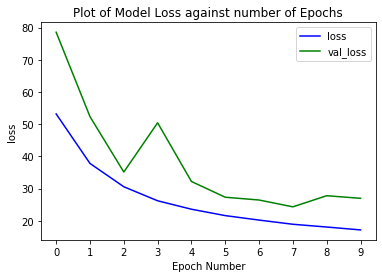

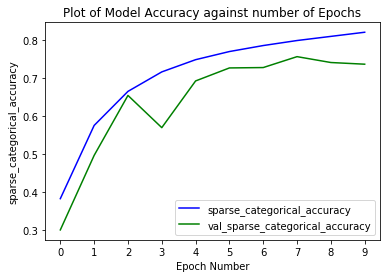

In [9]:
plot_metrics(metric_name = 'loss', title = 'Plot of Model Loss against number of Epochs', append = 'val_')
plot_metrics(metric_name = "sparse_categorical_accuracy", title = "Plot of Model Accuracy against number of Epochs", append = 'val_')

# Custom Training Loop

In [11]:
from tqdm import tqdm
class History:
    def __init__(self, metrics):
        self.history = {x:[] for x in metrics}

model = resnet_v1(input_shape=(32, 32, 3), depth=20)
optimizer = SGD(learning_rate = 0.01)
loss_object = SparseCategoricalCrossentropy(from_logits=False, reduction='sum')
accuracy_object = SparseCategoricalAccuracy()

# Make these metrics the same name as your variables later in the training loop
metrics = ['acc', 'loss', 'test_acc', 'test_loss']
history = History(metrics)

# Training Loop
for epoch in range(10):
    # Training Set
    losses = []
    accuracy_object.reset_states()
    pbar = tqdm(train_ds)
    for train_images, train_labels in pbar:
        with GradientTape() as tape:
            predictions = model(train_images, training=True)
            loss = loss_object(train_labels, predictions)
            losses.append(loss.numpy())
            accuracy_object.update_state(train_labels, predictions)
        pbar.set_description(f'Epoch: {epoch+1}, Train Loss: {np.mean(losses):.3f}, Train Acc: {accuracy_object.result().numpy():.3f}')
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = accuracy_object.result().numpy()
    loss = np.mean(losses)
    pbar.close()
        
    # Test Set
    losses = []
    accuracy_object.reset_states()
    pbar = tqdm(test_ds)
    for test_images, test_labels in pbar:
        with GradientTape() as tape:
            predictions = model(test_images, training=False)
            loss = loss_object(test_labels, predictions)
            losses.append(loss.numpy())
            accuracy_object.update_state(test_labels, predictions)
        pbar.set_description(f'Epoch: {epoch+1}, Test Loss: {np.mean(losses):.3f}, Test Acc: {accuracy_object.result().numpy():.3f}')
    test_acc = accuracy_object.result().numpy()
    test_loss = np.mean(losses)
    pbar.write(f'Epoch {epoch+1}, Train Loss: {loss}, Train Acc: {acc}, Test Loss: {test_loss}, Test Acc: {test_acc}')
    pbar.close()
    
    # Append the metrics, print to file
    with open('template2.txt', 'w') as f:
        for metric in metrics:
            history.history[metric].append(vars()[metric])
            print(history.history, file = f)

Epoch: 1, Train Loss: 53.318, Train Acc: 0.382: 100%|█| 1563/1563 [04:53<00:00, 
Epoch: 1, Test Loss: 43.785, Test Acc: 0.506: 100%|█| 313/313 [00:16<00:00, 19.2
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 1, Train Loss: 21.944141387939453, Train Acc: 0.3823400139808655, Test Loss: 43.7846565246582, Test Acc: 0.5059999823570251


Epoch: 2, Train Loss: 38.777, Train Acc: 0.564: 100%|█| 1563/1563 [04:54<00:00, 
Epoch: 2, Test Loss: 45.237, Test Acc: 0.538: 100%|█| 313/313 [00:16<00:00, 18.9
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 2, Train Loss: 17.42935562133789, Train Acc: 0.5644400119781494, Test Loss: 45.236732482910156, Test Acc: 0.5382000207901001


Epoch: 3, Train Loss: 31.506, Train Acc: 0.651: 100%|█| 1563/1563 [04:54<00:00, 
Epoch: 3, Test Loss: 35.582, Test Acc: 0.617: 100%|█| 313/313 [00:16<00:00, 19.1
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 3, Train Loss: 16.58789825439453, Train Acc: 0.6513800024986267, Test Loss: 35.5820426940918, Test Acc: 0.6171000003814697


Epoch: 4, Train Loss: 26.905, Train Acc: 0.704: 100%|█| 1563/1563 [04:53<00:00, 
Epoch: 4, Test Loss: 36.562, Test Acc: 0.618: 100%|█| 313/313 [00:16<00:00, 18.7
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 4, Train Loss: 11.808984756469727, Train Acc: 0.704259991645813, Test Loss: 36.562129974365234, Test Acc: 0.6182000041007996


Epoch: 5, Train Loss: 24.153, Train Acc: 0.738: 100%|█| 1563/1563 [04:55<00:00, 
Epoch: 5, Test Loss: 41.238, Test Acc: 0.627: 100%|█| 313/313 [00:16<00:00, 18.9
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 5, Train Loss: 7.4295454025268555, Train Acc: 0.7380399703979492, Test Loss: 41.237998962402344, Test Acc: 0.6265000104904175


Epoch: 6, Train Loss: 21.931, Train Acc: 0.763: 100%|█| 1563/1563 [04:54<00:00, 
Epoch: 6, Test Loss: 24.659, Test Acc: 0.741: 100%|█| 313/313 [00:16<00:00, 18.7
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 6, Train Loss: 12.398628234863281, Train Acc: 0.7630599737167358, Test Loss: 24.659337997436523, Test Acc: 0.7411999702453613


Epoch: 7, Train Loss: 20.377, Train Acc: 0.780: 100%|█| 1563/1563 [04:55<00:00, 
Epoch: 7, Test Loss: 28.066, Test Acc: 0.711: 100%|█| 313/313 [00:16<00:00, 18.9
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 7, Train Loss: 13.082052230834961, Train Acc: 0.7804800271987915, Test Loss: 28.066375732421875, Test Acc: 0.7110000252723694


Epoch: 8, Train Loss: 19.097, Train Acc: 0.795: 100%|█| 1563/1563 [04:55<00:00, 
Epoch: 8, Test Loss: 22.170, Test Acc: 0.764: 100%|█| 313/313 [00:16<00:00, 19.3
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 8, Train Loss: 6.461930274963379, Train Acc: 0.7950599789619446, Test Loss: 22.169837951660156, Test Acc: 0.7638000249862671


Epoch: 9, Train Loss: 17.931, Train Acc: 0.807: 100%|█| 1563/1563 [04:54<00:00, 
Epoch: 9, Test Loss: 32.241, Test Acc: 0.679: 100%|█| 313/313 [00:16<00:00, 18.8
  0%|                                                  | 0/1563 [00:00<?, ?it/s]

Epoch 9, Train Loss: 10.80162525177002, Train Acc: 0.8071200251579285, Test Loss: 32.240901947021484, Test Acc: 0.679099977016449


Epoch: 10, Train Loss: 17.141, Train Acc: 0.814: 100%|█| 1563/1563 [04:54<00:00,
Epoch: 10, Test Loss: 21.757, Test Acc: 0.781: 100%|█| 313/313 [00:16<00:00, 18.

Epoch 10, Train Loss: 5.309582710266113, Train Acc: 0.8139600157737732, Test Loss: 21.757190704345703, Test Acc: 0.7811999917030334


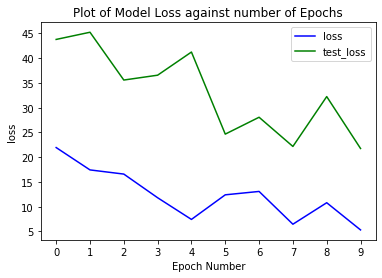

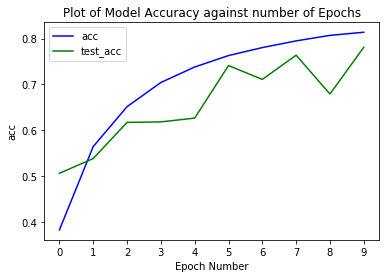

In [12]:
plot_metrics(metric_name = 'loss', title = 'Plot of Model Loss against number of Epochs', append = 'test_')
plot_metrics(metric_name = "acc", title = "Plot of Model Accuracy against number of Epochs", append = 'test_')